In [2]:
# Para instalar python_speech_features utilice en la consola de Python:
# pip install python_speech_features
# MFCC: Técnicas de extracción de características
# MFCC: Mel Frecuency Cepstral Coefficients
# MFCC: Matriz de coeficiente cepstral de frecuencia de Mel

'''
Primero, la entrada de audio se divide en varios segmentos en orden 
cronológico, y cada segmento se transforma en Fourier para obtener la
distribución de frecuencia correspondiente, y se extrae de ella la 
intensidad de energía correspondiente a las trece frecuencias 
características con la correlación más fuerte entre el contenido 
del lenguaje humano y el humano. Constituir una muestra. 
Las muestras de frecuencia obtenidas de cada muestra se forman en 
una matriz en filas, es decir, la matriz de Coeficiente Cepstral 
de Frecuencia Mel (MFCC).
'''

'''
La Escala Mel, propuesta por Stevens, Volkman y Newmann en 1937, 
es una escala musical perceptual de tonos juzgados 
como intervalos equiespaciados por parte de observadores
'''

'''
El cepstrum puede ser visto como una información del ritmo de cambio
de las diferentes bandas de un espectro. Fue originalmente desarrollado
para caracterizar los ecos de las ondas tectónicas, que provenían de 
terremotos y explosiones. También se utilizaba para analizar 
las señales captadas por un radar.El cepstrum de una señal es el 
resultado de calcular la transformada de Fourier inversa del espectro 
de la señal estudiada en escala logarítmica (dB). 
El cepstrum es complejo y, por tanto, tiene su parte real 
y su parte imaginaria.
'''

# Para instalar el paquete de reconocimiento de voz
# pip3 install hmmlearn

'''
Los Modelos Ocultos de Markov (MOM) son autómatas abstractos de 
estados finitos que permiten modelar procesos estocásticos, 
donde la ocurrencia de losestados está asociada con una distribución 
de probabilidad y donde las transicionesentre los estados
están gobernadas por un conjunto de probabilidades llamadas
probabilidades de transición de estados. En un estado particular, 
una observaciónse genera también de acuerdo a una distribución de 
probabilidad. Los estados noson visibles en general y su 
ocurrencia depende del estado en el instante anterior, 
de ahí el nombre de MOM
'''

# EJECUTAR EL CÓDIGO
# Este programa se debe ejecutar en la consola de Python
# Para ello utilice el siguiente comando:

# python reconocer_texto.py --input-folder data

# NOTA: El programa: reconocer_texto.py se incluye en la carpeta
# NOTA: Al final de este documento se incluye una imagen de ejecución

import os
import argparse 
import warnings

import numpy as np
from scipy.io import wavfile 

from hmmlearn import hmm
from python_speech_features import mfcc

# Define una función para analizar los argumentos de entrada
def build_arg_parser():
    parser = argparse.ArgumentParser(description='Entrena la voz basada en HMM: \
             sistema de reconocimiento')
    parser.add_argument("--input-folder", dest="input_folder", required=True,
            help="Carpeta de entrada que contiene los archivos de audio para entrenamiento.")
    return parser

# Define una clase para entrenar el HMM
class ModelHMM(object):
    def __init__(self, num_components=4, num_iter=1000):
        self.n_components = num_components
        self.n_iter = num_iter

        self.cov_type = 'diag' 
        self.model_name = 'GaussianHMM' 

        self.models = []

        self.model = hmm.GaussianHMM(n_components=self.n_components, 
                covariance_type=self.cov_type, n_iter=self.n_iter)

    # 'training_data' es un array numpy 2D donde cada fila es 13-dimensional
    def train(self, training_data):
        np.seterr(all='ignore')
        cur_model = self.model.fit(training_data)
        self.models.append(cur_model)

    # corre el modelo HMM para realizar inferencia sobre la entrada de datos
    def compute_score(self, input_data):
        return self.model.score(input_data)

# Define una función para construir un modelo para cada palabra
def build_models(input_folder):
    
    # Inicializar la variable para almacenar todos los modelos
    speech_models = []

    # Analiza el directorio de entrada
    for dirname in os.listdir(input_folder):
        
        # Obtiene el nombre del subfolder
        subfolder = os.path.join(input_folder, dirname)

        if not os.path.isdir(subfolder): 
            continue

        # Extrae la etiqueta
        label = subfolder[subfolder.rfind('/') + 1:]

        # Inicializa las variables
        X = np.array([])

        # Crea una lista de archivos a ser utilizados para el entrenamiento
        # Se deja un archivo por folder para validación
        training_files = [x for x in os.listdir(subfolder) if x.endswith('.wav')][:-1]

        # Se itera a través de los archivos de entrenamiento y se construyen los modelos
        for filename in training_files: 
            
            # Se extrae el path actual
            filepath = os.path.join(subfolder, filename)

            # Se lee la señal lde audio desde el archivo de entrada
            sampling_freq, signal = wavfile.read(filepath)
            
            # Se extraen las características MFCC
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                features_mfcc = mfcc(signal, sampling_freq)

            # Se agrega a la variable X
            if len(X) == 0:
                X = features_mfcc
            else:
                X = np.append(X, features_mfcc, axis=0)
            
        # Se crea el modelo HMM
        model = ModelHMM()

        # Se entrena el HMM
        model.train(X)

        # Se almacena el modelo para la palabra actual
        speech_models.append((model, label))

        # Se reinicia la variable
        model = None

    return speech_models

# Define una función para ejecutar pruebas sobre los archivos de entrada
def run_tests(test_files):
    
    # Clasifica los datos de entrada
    for test_file in test_files:
        
        # Lee el archivo de entrada
        sampling_freq, signal = wavfile.read(test_file)

        # Extrae las características MFCC
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            features_mfcc = mfcc(signal, sampling_freq)

        # Define variables
        max_score = -float('inf') 
        output_label = None 
        
        # Ejecuta el vector de características actual a través
        # de todos los modelos HMM y elige el que tenga el
        # puntaje más alto
        for item in speech_models:
            model, label = item
            score = model.compute_score(features_mfcc)
            if score > max_score:
                max_score = score
                predicted_label = label

        # Muestra la salida prevista 
        start_index = test_file.find('/') + 1
        end_index = test_file.rfind('/')
        original_label = test_file[start_index:end_index]
        print('\nOriginal: ', original_label) 
        print('Predicción:', predicted_label)

if __name__=='__main__':
    args = build_arg_parser().parse_args()
    input_folder = args.input_folder

    # Construye el modelo HMM para cada palabra
    speech_models = build_models(input_folder)

    #  Verifica los archivos -- el archivo 15 en cada subfolder
    test_files = []
    for root, dirs, files in os.walk(input_folder):
        for filename in (x for x in files if '15' in x):
            filepath = os.path.join(root, filename)
            test_files.append(filepath)

    run_tests(test_files)

usage: ipykernel_launcher.py [-h] --input-folder INPUT_FOLDER
ipykernel_launcher.py: error: the following arguments are required: --input-folder


SystemExit: 2

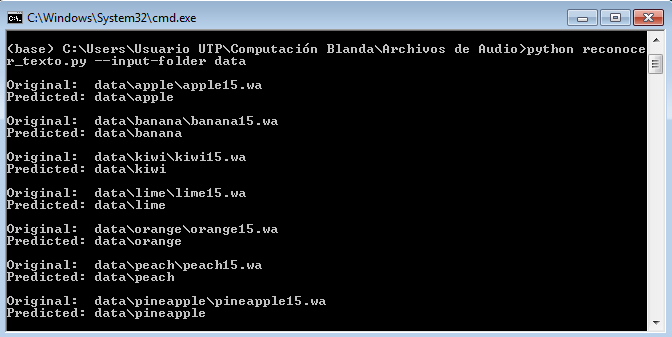